# **Imports**

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
import matplotlib.dates as mdates

from tqdm import tqdm

from transformers import BertTokenizer
from sklearn.linear_model import LinearRegression

import paths_ml_task_1 as PATHS



import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from datasets import Dataset
import re
from tqdm import tqdm
import paths_ml_task_1 as PATHS
from gensim.models.doc2vec import TaggedDocument, Doc2Vec


# **Introduction - Get acquainted with the data**

This notebook addresses the **Machine Learning Task 1** of our project Political Language Processing:

> **Can we automatically identify the political party of a speaker solely based on their transcribed speech in the German Bundestag?**

To tackle this classification task, we apply various NLP preprocessing techniques and train supervised machine learning models to identify patterns in political language that are indicative of specific parties.


---


## **Data Scope**

The foundation for this task are the following structured speech datasets from our custom [Data Generation Pipeline's](../dataGeneration/dataGenerationPipeline/dataGenerationPipeline_1.ipynb) final output stage, containing **all available plenary speeches** from the **19th and 20th legislative periods** of the German Bundestag:

```
data/
├── dataFinalStage/
│   ├── speechContentFinalStage/
│   │   ├── speech_content_19_20.pkl
│   │   ├── speech_content_19.pkl
│   │   └── speech_content_20.pkl
│   ├── contributionsSimplifiedFinalStage/
│   │   ├── contributions_simplified_19.pkl
│   │   ├── contributions_simplified_20.pkl
│   │   └── contributions_simplified_19_20.pkl
│   └── factionsAbbreviations.pkl
```

- **Preprocessing-friendly structure:** With each datapoint including the **full speech content**, speaker metadata (e.g., name, role, party affiliation), and timestamp information for one speech, these datasets provide a comprehensive and semantically rich basis for downstream preprocessing, training and evaluation workflows.
    The speeches were extracted from official plenary protocol documents `<session-number>.xml` released for each sitting by the Bundestag and systematically transformed into **machine-readable tabular formats**: All markup has been removed from the speech content and texts are stored in plain UTF-8 format with clear separation of metadata and content.

- **Contributions (interjections, applause, etc.)** have been **systematically extracted** from the main speech text and stored separately during data generation step 4.1. However, **position markers** (e.g., `({1})`, `({2})`) have been inserted into the text at the corresponding positions as placeholders, enabling accurate **re-insertion** at any time.


---


## **Columns (speech_content_*.pkl):**

| Column            | Description                                         |
|-------------------|-----------------------------------------------------|
| `id`              | Unique ID for each speech block                     |
| `electoral_term`  | Electoral period (e.g., 19, 20)                     |
| `session`         | Session number within the term                      |
| `first_name`      | First name of the speaker                           |
| `last_name`       | Last name of the speaker                            |
| `faction_id`      | Faction ID assigned to the speaker                  |
| `position_short`  | Speaker's role (e.g., MP, Minister)                 |
| `position_long`   | Full position title (e.g., "Bundesminister für...") |
| `politician_id`   | Unique politician ID (ui)                           |
| `speech_content`  | Full speech text (without contributions)            |
| `date`            | Session date (in Unix time format)                  |
| `document_url`    | Link to original PDF of session                     |


---


## **Label Handling: Faction Encoding**

- During [data generation](../dataGeneration/dataGenerationPipeline/dataGenerationPipeline_1.ipynb) each speaker in the dataset is assigned a **numerical `faction_id`**, which serves as a unique identifier for their political party.
- While the final visualizations often involve textual party abbreviations, working with numeric identifiers internally offers several advantages, including **faster lookups and comparisons** as well as the elimination of issues related to **spelling variations** or encoding.
- It is important to note that **`faction_id`s are not sequential integers from 0 to N**, but sparsely distributed over the number line:
    - This **non-contiguous mapping** stems from the [Data Generation Pipeline](../dataGeneration/dataGenerationPipeline/dataGenerationPipeline_1.ipynb) being built to support future extensions to **earlier electoral terms**. Historically, many additional parties were represented in the Bundestag, and this ID scheme ensures compatibility and uniqueness across ALL time periods.
    - **Implication for deep learning models:** Since many machine learning libraries (e.g., PyTorch, TensorFlow) expect **zero-based, sequential label indices**, a **`LabelEncoder`** must be applied before feeding `faction_id` values into neural networks such as BERT-based classifiers.
    This encoding step ensures compatibility with loss functions like `CrossEntropyLoss`, which rely on dense class indices.

| Party                    | `faction_id` |
|--------------------------|--------------|
| AfD                      | 0            |
| Bündnis 90/Die Grünen    | 4            |
| DIE LINKE.               | 7            |
| CDU/CSU                  | 5            |
| FDP                      | 15           |
| SPD                      | 25           |
| BSW                      | 3            |
| Fraktionslos             | 18           |


---


## **Special Cases in Speaker Affiliation during Parsing**

During the data generation process, several specific challenges arose that will later require filtering steps to ensure the integrity of downstream classification and statistical analyses:

- **Handling of Ministerial Speeches:** In the German Parliament, ministers are considered to speak as representatives of the **Federal Government**, not of their respective parties.
    - Although their party affiliation exists, it is not directly stated in the XML files provided by the Bundestag: Their speeches are only labeled with their **official role** (e.g. `<role>Minister of Defense</role>`) instead of a faction (e.g. `<fraktion>DIE LINKE.</fraktion>`).
    - While their statements formally represent the **governments position**, ministers still remain party members and — and their speeches often reflect party-specific semantics useful for classification.

> We **reassigned ministers to their party affiliation** using a dedicated politician metadata lookup table during data generation.

- **Handling of Moderation Speeches:**
    - The following speaker groups are responsible for moderating Bundestag sessions:
        - President of the Bundestag (1 person)
        - Vice Presidents (5–6 people)
        - Secretaries (20–40 people)
    - These individuals frequently make short, repetitive and formulaic announcements (e.g., “Next speaker: XYZ”), which can distort analyses:
       **ML classifiers** might learn to associate certain formulaic phrases with a particular party (e.g., that of the President).

> All such entries are marked as `"Presidium of Parliament"` in the `position_short` column during data generation step 4.1 and can be **safely excluded** from learning and evaluation datasets.

- **Parsing Errors and Missing Party Affiliation:**
    - In some cases, speeches could not be linked to a party due to:
        - Structural inconsistencies or inconsistencies in the XML plenary protocols,
        - ambiguities in speaker identification (When no unique speaker ID is available, matching is done via fuzzy name and role matching, but that does not always work),
        - or edge cases where the rule-based parser fails.
        - ...

> The between 1000 and 2000 speeches per term that fall into this category are assigned `faction_id = -1`. Based on that, they can be **safely excluded** from datasets used for training and evaluation, ensuring data integrity.


In [3]:
"""
Parser Quality
"""
print("Quick look at the parser performance:")
valid_ids = [0, 3, 4, 5, 7, 15, 25]
count_bad = 0
count_good = 0
for term in [19, 20]:
    df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_DIR / f"speech_content_{term}.pkl")
    # Filter out Presidium speeches
    df = df[df["position_short"] != "Presidium of Parliament"]
    # Count speeches with faction_id == -1
    count_missing_faction = (df["faction_id"] == -1).sum()
    count_bad = count_bad + count_missing_faction
    count_good_data_points = df["faction_id"].isin(valid_ids).sum()
    count_good = count_good + count_good_data_points
    print(f" - {count_missing_faction} badly labeled speeches (faction_id==-1) stand across {count_good_data_points} valid speeches in electoral term {term}.")
print(f" - {count_bad} badly labeled speeches (faction_id==-1) stand across {count_good} valid speeches in electoral terms 19 and 20 combined.")

Quick look at the parser performance:
 - 1151 badly labeled speeches (faction_id==-1) stand across 32991 valid speeches in electoral term 19.
 - 1934 badly labeled speeches (faction_id==-1) stand across 32042 valid speeches in electoral term 20.
 - 3085 badly labeled speeches (faction_id==-1) stand across 65033 valid speeches in electoral terms 19 and 20 combined.


ﬁ# **Understanding Party-Level Speech Dynamics**

Since the performance of classification models heavily depends on data quality and preprocessing choices, it is essential to first build a **solid understanding of the speech data's structure and distribution** before diving into classification and modeling tasks. The following section presents four complementary perspectives that will help us detect potential issues like class imbalance or outliers that may affect model performance.

1. **Class Distribution – Number of Speeches per Party:**
    Understanding the class distribution is crucial, as heavy class imbalance may bias classifiers to majority parties.

2. **Speaker Distribution – Unique Speakers per Party:**
    Understanding how many different individuals represent each party helps assess rhetorical diversity and robustness.

3. **Temporal Distribution – Party Activity Over Time:**
    Some parties may dominate certain periods. Identifying this helps avoid time-based bias in training/testing splits.

4. **Length Distribution  –  Characters and BERT Tokens per Speech:**
   This examination reveals outlier datapoints — both very short and very long speeches — that may negatively impact learning.

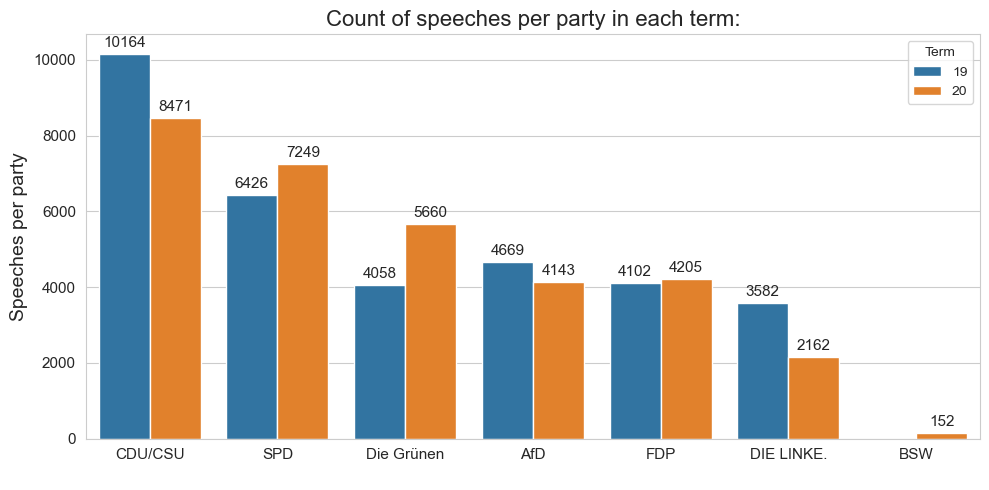

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/3428751836.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


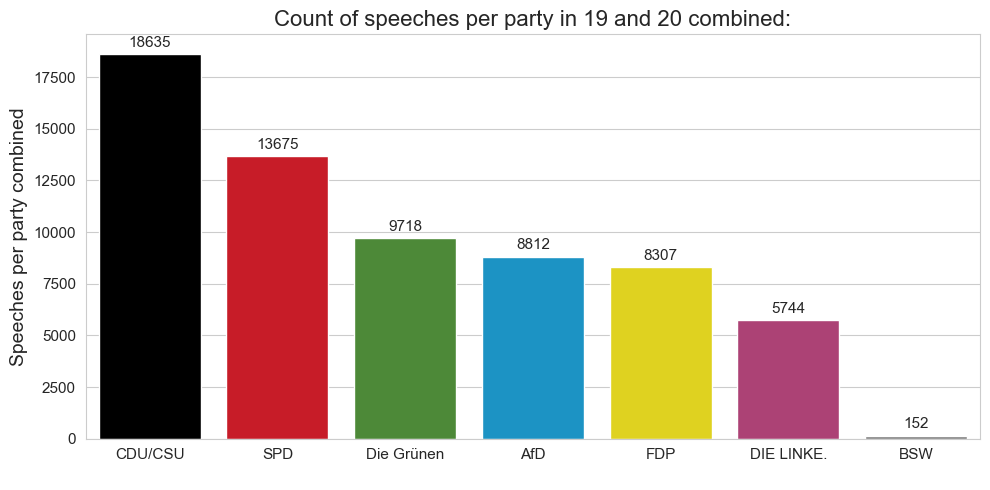

In [116]:
"""
1. Class Distribution – Number of Speeches per Party:
"""
# load faction abbreviation map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Prepare combined DataFrame
combined_counts = []

for term in [19, 20, "19_20"]:
    # load speech data
    df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_DIR / f"speech_content_{term}.pkl")
    # map party abbreviation
    df["party"] = df["faction_id"].map(faction_map)
    # count speeches per party
    party_counts = df["party"].value_counts()
    # append to list
    for party, count in party_counts.items():
        combined_counts.append({"party": party, "Term": str(term), "count": count})

# Create DataFrame for plotting
df_counts = pd.DataFrame(combined_counts)

# Replace long name with short name for display
df_counts["party"] = df_counts["party"].replace({"Bündnis 90/Die Grünen": "Die Grünen"})
# Adjust order and color mapping accordingly
order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE.", "BSW"] # falling order on combined dataset to ensurcomparability of both plots
palette = {
    "19": "#1f77b4",      # blue
    "20": "#ff7f0e",      # orange
}
party_colors = {
    "CDU/CSU": "#000000",         # black
    "SPD": "#E3000F",             # red
    "Die Grünen": "#46962B",      # green
    "FDP": "#FFED00",             # yellow
    "AfD": "#009EE0",             # blue
    "DIE LINKE.": "#BE3075",      # magenta
    "BSW": "#808080"              # grey
}

# === Plot: Combined barplot (19 + 20) ===
df_subset = df_counts[df_counts["Term"].isin(["19", "20"])]

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_subset, x="party", y="count", hue="Term", order=order, palette=palette)
plt.title("Count of speeches per party in each term:", fontsize=16)
plt.ylabel("Speeches per party", fontsize=14)
plt.xlabel(" ")
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
# Values above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=11)
plt.tight_layout()
plt.show()


# === Plot: Full combined dataset "19 and 20 combined" ===
df_combined_only = df_counts[df_counts["Term"] == "19_20"]

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_combined_only,
    x="party",
    y="count",
    order=order,
    palette=party_colors
)
plt.title("Count of speeches per party in 19 and 20 combined:", fontsize=16)
plt.ylabel("Speeches per party combined", fontsize=14)
plt.xlabel(" ")
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
# Values above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=11)
plt.tight_layout()
plt.show()

## **1 Initial Class Distribution – Number of Speeches per Party**

| Party                 | 19th Electoral Term |  20th Electoral Term |  Combined 19th & 20th Term |
|-----------------------|--------------------:|---------------------:|---------------------------:|
| CDU/CSU               |              10,164 |                8,471 |                     18,635 |
| SPD                   |               6,426 |                7,249 |                     13,675 |
| Bündnis 90/Die Grünen |               4,058 |                5,660 |                      9,718 |
| AfD                   |               4,669 |                4,143 |                      8,812 |
| FDP                   |               4,102 |                4,205 |                      8,307 |
| DIE LINKE.            |               3,582 |                2,162 |                      5,744 |
| Fraktionslos          |                 206 |                  874 |                      1,080 |
| BSW                   |                   – |                  152 |                        152 |


### **Interpretation and Class Handling Strategy**

Imbalanced class distributions are a common challenge in supervised learning, as dominant classes may bias the model’s predictions. When inspecting the statistics, we can immediately identify two classes that stand out due to their disproportionately low sample counts: `Fraktionslos` and `BSW`.

- **`Fraktionslos`** (unaffiliated speakers): Although technically a separate class, this group is **not semantically cohesive** and typically does not follow a unified rhetorical style. Since our goal is to train models that capture **party-specific rhetoric**, this class is **not of analytical interest** and will be **removed** entirely from the datasets used for model training and evaluation.

- **`BSW`** (Bündnis Sahra Wagenknecht): This party only appears in the 20th term and contributes **just 152 speeches** in total, but it still represents a closed party. So rather than removing this class entirely, we conducted a **[dedicated experiment showing that `BSW` speeches can be merged into the class `DIE LINKE.`](ML-Task-1_Classification_Experiments.ipynb)** — both due to semantic proximity and shared political history. This approach helps support the **next weakest class** (`DIE LINKE.`) and improves class balance without losing valuable data.

- **Class Imbalance and Model Impact:**
    - The class distribution across parties is imbalanced: The strongest class `CDU/CSU` accounts for **over 18,600 speeches**, while `DIE LINKE.`. (even after merging `BSW`) has just **around 5,900**. Importantly, a higher number of speeches does not just mean more data — it also likely reflects a greater rhetorical and topical diversity within that class giving majority classes an additional advantage.
    - Such disparities can severely bias supervised machine learning models, especially deep classifiers like BERT, which are sensitive to **frequency-driven overfitting**.
    - Without appropriate countermeasures such as **class weighting or stratified sampling** models are may **overpredict majority classes** while underperforming on minority ones.

- **Class Dynamics Across Legislative Terms that reflect broader political developments in Germany:**
    - `DIE LINKE.` shows a decline in speaking engagements, coinciding with the 2021 electoral losses and the eventual split leading to the foundation of BSW.
    - Meanwhile, `Bündnis 90/Die Grünen` increased their speech activity significantly, which correlates with their new government role as part of the “Ampelkoalition” (SPD–Grüne–FDP). The `SPD`, as the leading coalition party, also saw a notable increase in speech frequency.


/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_term, x="party", y="unique_speakers", ax=ax, order=order, palette=palette)
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_term, x="party", y="unique_speakers", ax=ax, order=order, palette=palette)


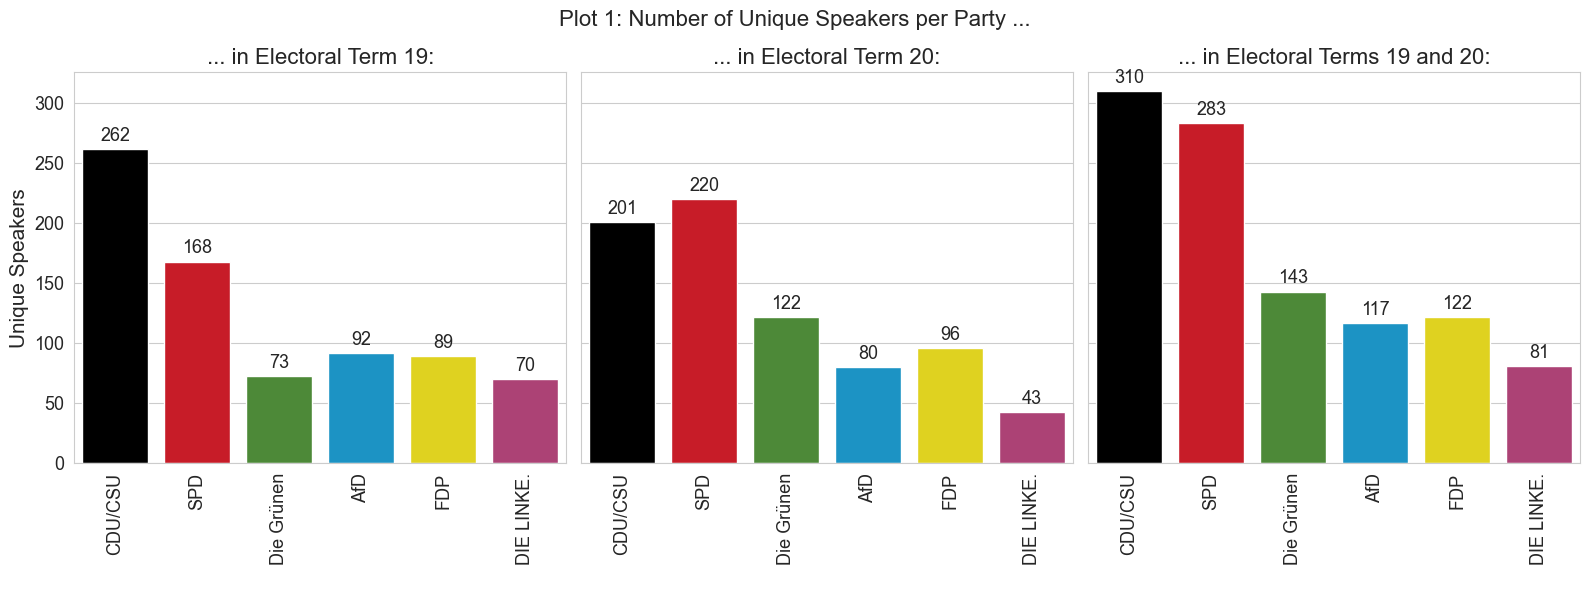

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_term["size_scaled"] = df_term["mean_speeches_per_speaker"] * 4 # scale for visibility
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_term["size_scaled"] = df_term["mean_speeches_per_speaker"] * 4 # scale for visibility


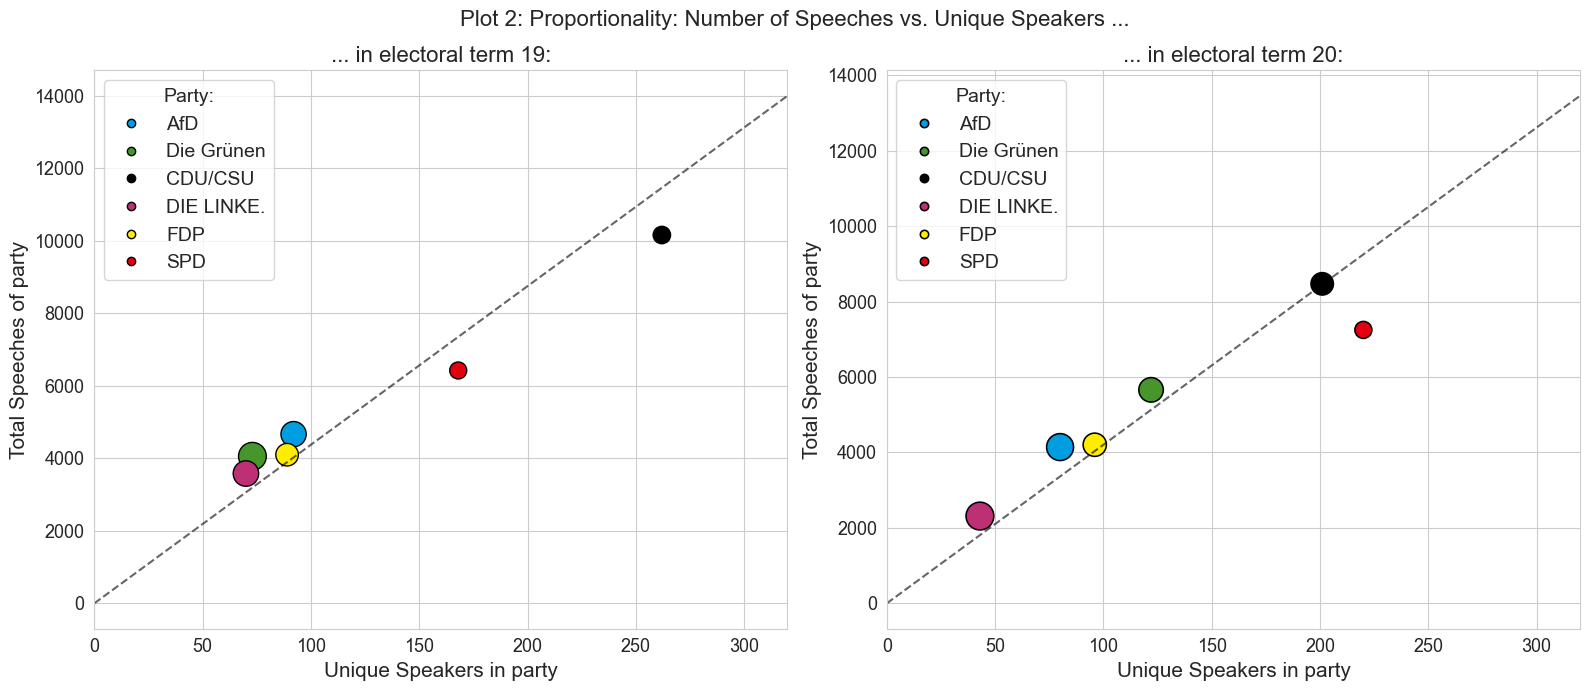

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_term, x="party", y="mean_speeches_per_speaker", ax=ax, order=order, palette=palette)
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_2324/635642255.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_term, x="party", y="mean_speeches_per_speaker", ax=ax, order=o

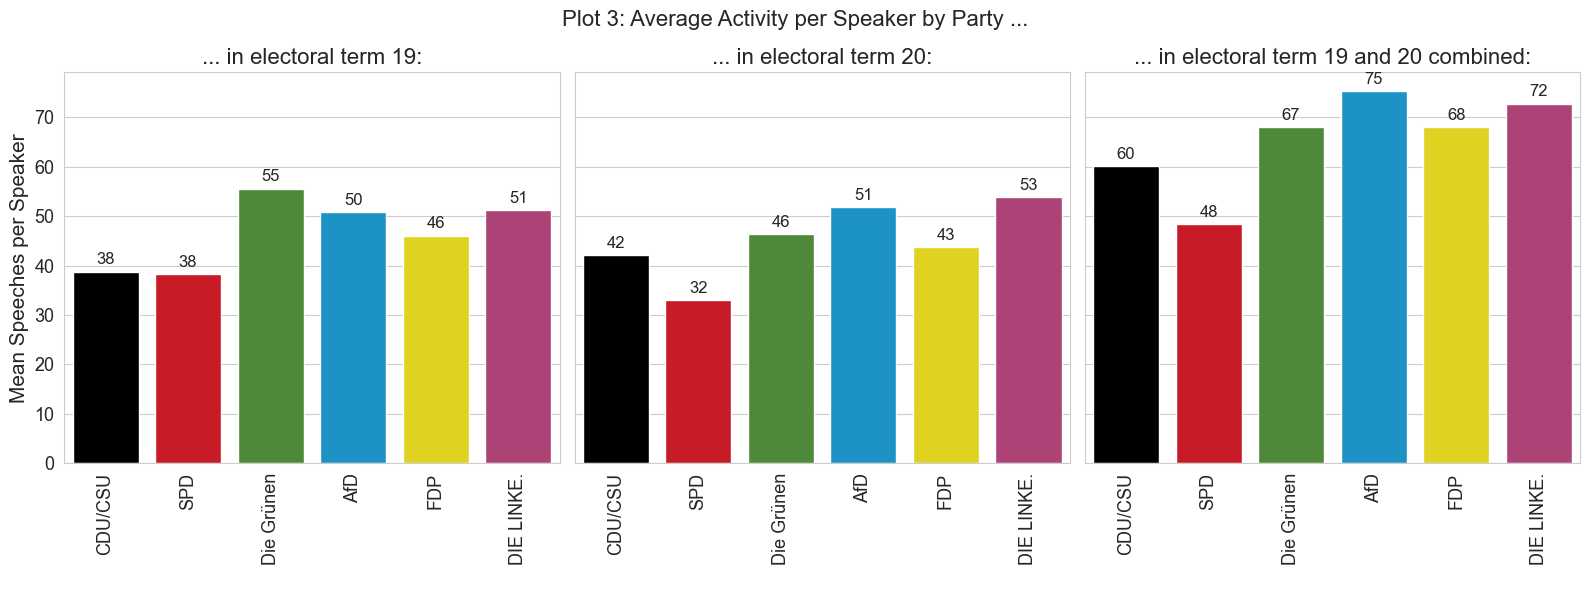

In [121]:
"""
2. Speaker Distribution – Unique Speakers per Party:
"""
# Load faction abbreviation map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Prepare data
speaker_stats = []

for term in [19, 20, "19_20"]:
    df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_DIR / f"speech_content_{term}.pkl")
    df = df[df["faction_id"] != 18]
    df.loc[df["faction_id"] == 3, "faction_id"] = 7
    df["party"] = df["faction_id"].map(faction_map)
    grouped = df.groupby(["party", "politician_id"]).size().reset_index(name="speech_count")
    summary = grouped.groupby("party").agg(
        unique_speakers=("politician_id", "nunique"),
        total_speeches=("speech_count", "sum"),
        mean_speeches_per_speaker=("speech_count", "mean"),
        median_speeches_per_speaker=("speech_count", "median"),
        max_speeches_per_speaker=("speech_count", "max"),
    ).reset_index()
    summary["Term"] = term
    speaker_stats.append(summary)


# Create DataFrame for plotting
df_speaker_stats = pd.concat(speaker_stats, ignore_index=True)

# Replace long name with short name for display
df_speaker_stats["party"] = df_speaker_stats["party"].replace({"Bündnis 90/Die Grünen": "Die Grünen"})
# Adjust order and color mapping accordingly
order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
party_colors = {
    "CDU/CSU": "#000000",         # black
    "SPD": "#E3000F",             # red
    "Die Grünen": "#46962B",  # green
    "FDP": "#FFED00",             # yellow
    "AfD": "#009EE0",             # blue
    "DIE LINKE.": "#BE3075",      # magenta
}


# === Plot 1: Unique Speakers per Party ===
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
for i, term in enumerate([19, 20, "19_20"]):
    df_term = df_speaker_stats[df_speaker_stats["Term"] == term]
    # map party colors
    palette = {party: party_colors.get(party, "#808080") for party in df_term["party"].unique()}
    # Barplot with partycolors
    ax = axs[i]
    sns.barplot(data=df_term, x="party", y="unique_speakers", ax=ax, order=order, palette=palette)
    # titles and legend
    ax.set_title(f"... in Electoral {'Terms 19 and 20' if term == '19_20' else f'Term {term}'}:", fontsize=16)
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel(" ")
    if i == 0:
        ax.set_ylabel("Unique Speakers", fontsize=15)
    else:
        ax.set_ylabel("")
    # Rotate x-axis labels and set font size
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    # Write values above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=13)
plt.suptitle("Plot 1: Number of Unique Speakers per Party ...", fontsize=16)
plt.tight_layout()
plt.show()


# === Plot 2: Scatterplot – Total Speeches vs Unique Speakers ===
global_max_x = df_speaker_stats["unique_speakers"].max()
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for i, term in enumerate([19, 20]):
    df_term = df_speaker_stats[df_speaker_stats["Term"] == term]
    df_term["size_scaled"] = df_term["mean_speeches_per_speaker"] * 4 # scale for visibility
    ax = axs[i]
    sns.scatterplot(
        data=df_term,
        x="unique_speakers",
        y="total_speeches",
        size="size_scaled",
        sizes=(150, 400),     # min and max size of bubbles
        hue="party",
        palette=party_colors,
        edgecolor="black",
        ax=ax,
        legend="brief"
    )
    # Remove automatic size legend entry
    handles, labels = ax.get_legend_handles_labels()
    # Keep only entries from hue="party"
    hue_labels = df_term["party"].unique().tolist()
    filtered = [(h, l) for h, l in zip(handles, labels) if l in hue_labels]
    ax.legend(*zip(*filtered), fontsize=14, title="Party:", title_fontsize=14)

    # Proportional line: speeches per speaker if everyone had ~ the same number
    x_vals = np.array([0, global_max_x + 10])
    avg_ratio = df_term["total_speeches"].sum() / df_term["unique_speakers"].sum()
    y_vals = avg_ratio * x_vals
    ax.plot(x_vals, y_vals, 'k--', alpha=0.6, label="~Uniform Activity")

    ax.set_title(f"... in electoral term {term if term != '19_20' else '19 and 20 combined'}:", fontsize=16)
    ax.set_xlabel("Unique Speakers in party", fontsize=15)
    ax.set_ylabel("Total Speeches of party", fontsize=15)
    ax.set_xlim(0, global_max_x + 10)  # +10 für etwas Puffer
    ax.tick_params(axis='both', labelsize=13)  # <--- Tick label size
    #ax.legend(fontsize=12, title="Party:", title_fontsize=15)

plt.suptitle("Plot 2: Proportionality: Number of Speeches vs. Unique Speakers ...", fontsize=16)
plt.tight_layout()
plt.show()


# === Plot 3: Mean Speeches per Speaker ===
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

for i, term in enumerate([19, 20, "19_20"]):
    df_term = df_speaker_stats[df_speaker_stats["Term"] == term]
    palette = {party: party_colors.get(party, "#808080") for party in df_term["party"].unique()}
    ax = axs[i]
    sns.barplot(data=df_term, x="party", y="mean_speeches_per_speaker", ax=ax, order=order, palette=palette)
    ax.set_title(f"... in electoral term {term if term != '19_20' else '19 and 20 combined'}:", fontsize=16)
    ax.tick_params(axis='x', rotation=90, labelsize=13)
    ax.set_xlabel(" ")
    if i == 0:
        ax.set_ylabel("Mean Speeches per Speaker", fontsize=15)
    else:
        ax.set_ylabel("")
    # Rotate x-axis labels and set font size
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    # Write values above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=12)

plt.suptitle("Plot 3: Average Activity per Speaker by Party ...", fontsize=16)
plt.tight_layout()
plt.show()


# Report:
#display(df_speaker_stats.sort_values(by=["Term", "unique_speakers"], ascending=[True, False]))
# Output Markdown-formatted tables
#for term in [19, 20, "19_20"]:
#    df_term = df_speaker_stats[df_speaker_stats["Term"] == term]
#    print(f"### Unique Speaker Statistics – Term {term}\n")
#    print(df_term.to_markdown(index=False))
#    print("\n")


## **2 Speaker Distribution – Unique Speakers per Party**


### **Speaker Statistics:**

**Electoral Term 19:**
| Party                 | Unique Speakers | Number of Speeches | Mean Speeches Per Speaker | Median Speeches Per Speaker | Max Speeches Per Speaker |
|:----------------------|----------------:|-------------------:|--------------------------:|----------------------------:|-------------------------:|
| AfD                   |              92 |               4669 |                     50.75 |                        44.5 |                      171 |
| Bündnis 90/Die Grünen |              73 |               4058 |                    55.589 |                          59 |                      135 |
| CDU/CSU               |             262 |              10164 |                   38.7939 |                          28 |                      382 |
| DIE LINKE.            |              70 |               3582 |                   51.1714 |                          47 |                      123 |
| FDP                   |              89 |               4102 |                   46.0899 |                          40 |                      125 |
| SPD                   |             168 |               6426 |                     38.25 |                        31.5 |                      255 |

**Electoral Term 20:**
| Party                 | Unique Speakers | Number of Speeches | Mean Speeches Per Speaker | Median Speeches Per Speaker | Max Speeches Per Speaker |
|:----------------------|----------------:|-------------------:|--------------------------:|----------------------------:|-------------------------:|
| AfD                   |              80 |               4143 |                   51.7875 |                        46.5 |                      274 |
| Bündnis 90/Die Grünen |             122 |               5660 |                   46.3934 |                          38 |                      229 |
| CDU/CSU               |             201 |               8471 |                   42.1443 |                          35 |                      150 |
| DIE LINKE.            |              43 |               2314 |                    53.814 |                          46 |                      140 |
| FDP                   |              96 |               4205 |                   43.8021 |                          34 |                      204 |
| SPD                   |             220 |               7249 |                     32.95 |                        24.5 |                      371 |

**Electoral Terms 19 and 20 combined:**
| Party                 | Unique Speakers |  Number of Speeches | Mean Speeches Per Speaker | Median Speeches Per Speaker | Max Speeches Per Speaker |
|:----------------------|----------------:|--------------------:|--------------------------:|----------------------------:|-------------------------:|
| AfD                   |             117 |                8812 |                   75.3162 |                          52 |                      445 |
| Bündnis 90/Die Grünen |             143 |                9718 |                    67.958 |                          55 |                      297 |
| CDU/CSU               |             310 |               18635 |                   60.1129 |                          42 |                      382 |
| DIE LINKE.            |              81 |                5896 |                   72.7901 |                          65 |                      234 |
| FDP                   |             122 |                8307 |                   68.0902 |                        60.5 |                      257 |
| SPD                   |             283 |               13675 |                   48.3216 |                          38 |                      507 |


### **Interpreting Speaker Statistics and Implications for Classification**

Analyzing how many unique individuals (`politician_id`) are active within each party across the 19th, 20th, and combined legislative terms (speaker distribution) reveals important insights relevant to our classification pipeline: For example it helps to assess intra-class semantic variation and the potential risk of overfitting to speaker-specific language styles.

1. **Proportionality Between Speakers and Speeches**
    - Across all parties and terms, there is a clear correlation between the number of unique speakers and the total number of speeches: Parties with more speakers also tend to contribute more speeches.
    - This **near-linear proportionality** is a favorable signal for training supervised models, as it indicates that no party is overrepresented in terms of individual activity and therefore mitigates the risk of overfitting to outlier speakers and improves the robustness of party-level generalization.
    The proportionality across parties and terms is clearly made visible by the diagonal reference line in `Plot 2: Proportionality`, where each point represents a party (and is sized according to its average speeches per speaker).
2. **Per-Speaker Variability and Outliers**
    - The statistics also show reasonable mean and median values for speeches per speaker across parties. This **even distribution** of the speaking activity across speakers can be seen in `Plot 3: Average Activity`.
    - While maximum values suggest the presence of a few prolific speakers, these are not extreme enough to dominate the dataset. For instance: SPD in term 19_20 has a speaker with 507 speeches, yet the median is only 38, reflecting a long-tail distribution.
3. **Consistency Across Terms**
    - The distribution of unique speakers per party displayed in Plot 1 is remarkably consistent between legislative periods, which — if we consider that **speaker identity is a strong proxy for party affiliation** — indicates that models trained on one term could generalize well to the next.
4. **Implications for Train-Test Splits and Model Design**
    - The proportionality between speaker counts and speech volume adds robustness, while the absence of sharp skews allows for straightforward application of standard training pipelines: Splits based on speeches should **implicitly balance** speaker diversity across classes.
    - There’s no indication of strong class imbalance at the speaker level, suggesting no immediate need for aggressive speaker-based oversampling or reweighting.


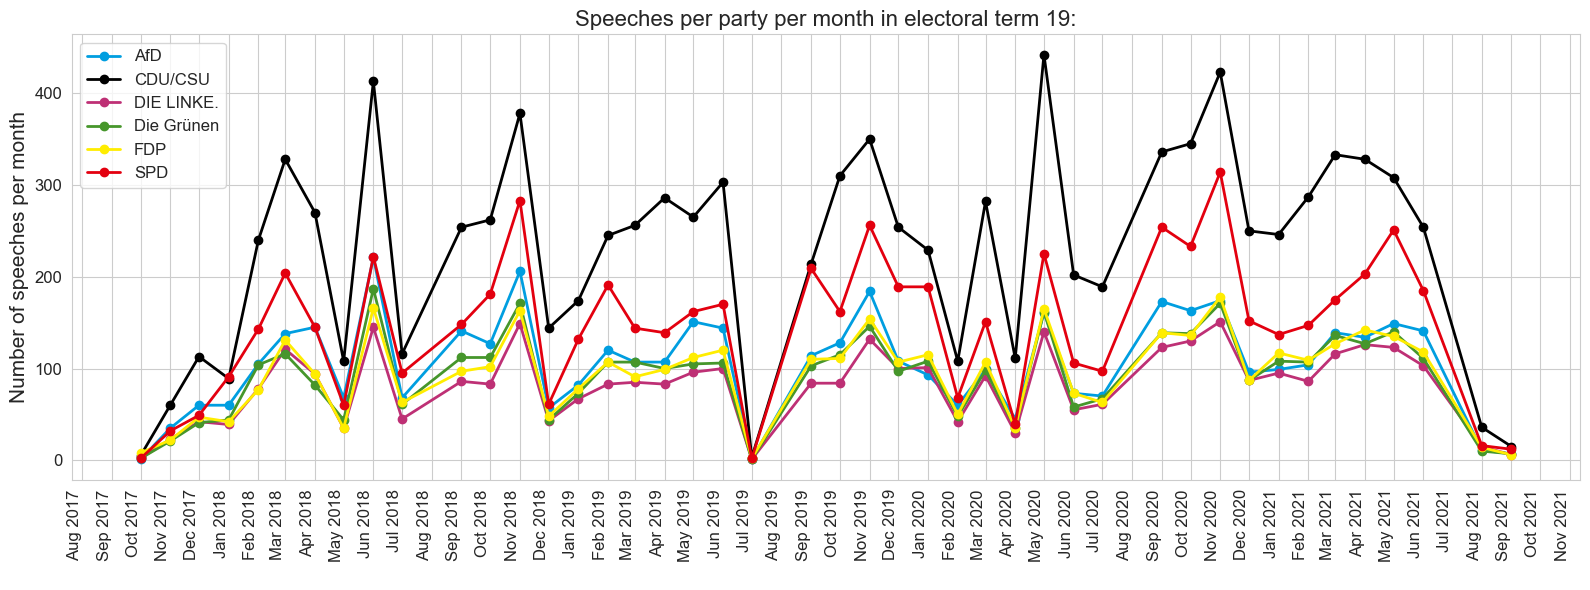

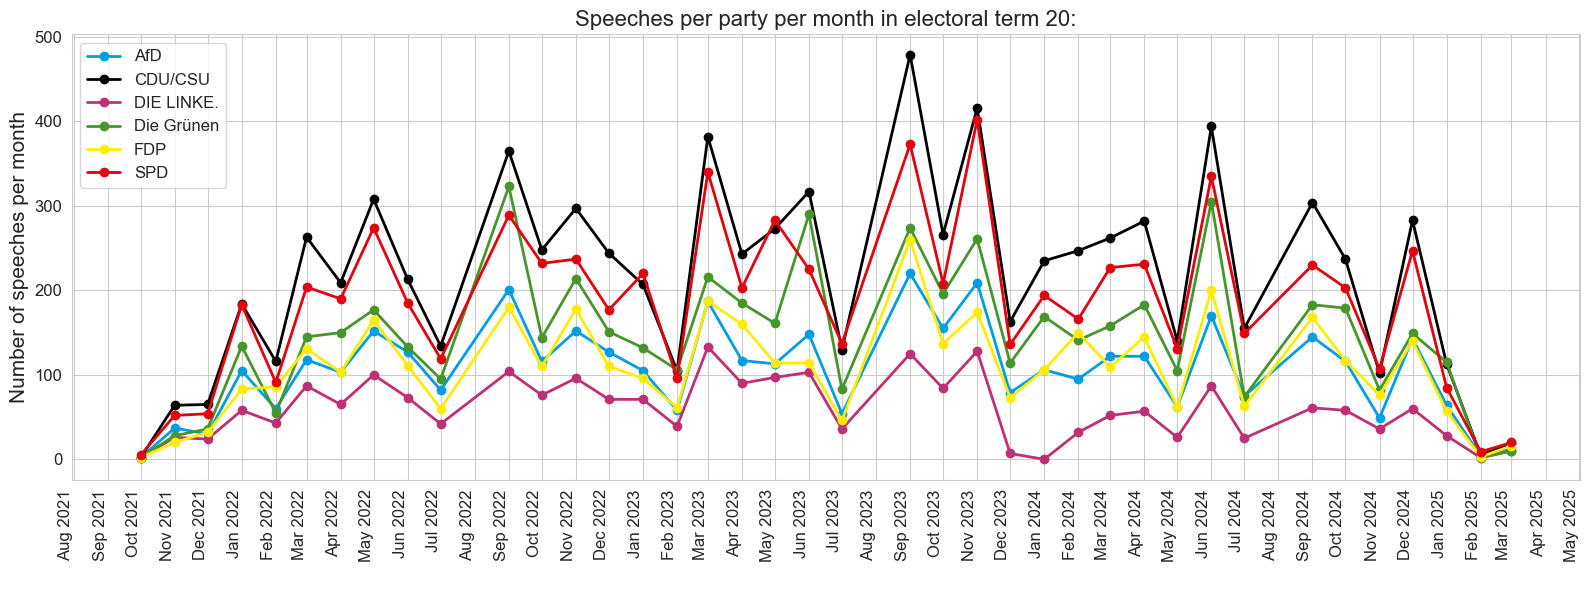

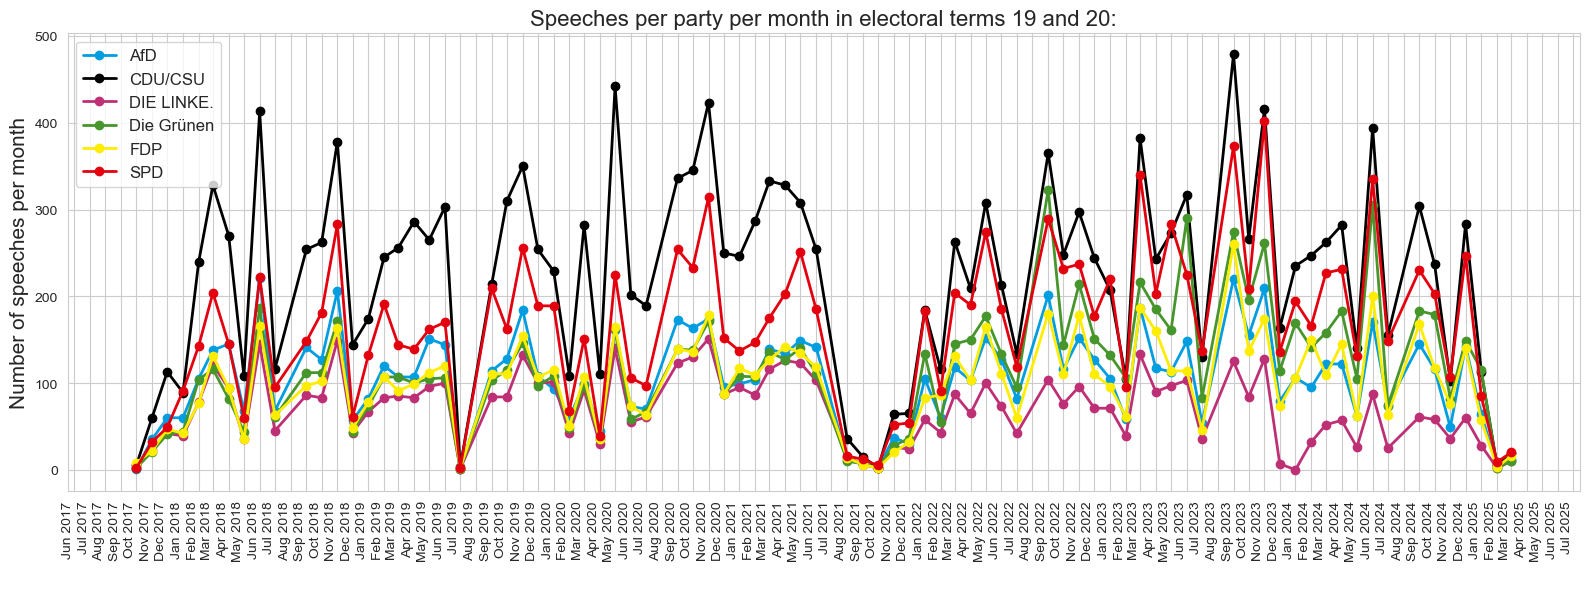

In [131]:
"""
3. Temporal Distribution – Party Activity Over Time:
"""
# load faction abbreviation map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Prepare combined DataFrame
combined_counts = []

# custom colors in plots
party_colors = {
    "CDU/CSU": "#000000",         # black
    "SPD": "#E3000F",             # red
    "Die Grünen": "#46962B",  # green
    "FDP": "#FFED00",             # yellow
    "AfD": "#009EE0",             # blue
    "DIE LINKE.": "#BE3075",      # magenta
}


for term in [19, 20, "19_20"]:
    # load speech data
    df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_DIR / f"speech_content_{term}.pkl")
    df = df[df["faction_id"] != 18] # Remove speeches by independent members (faction_id == 18)
    df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
    df["date"] = pd.to_datetime(df["date"], unit='s') # date format

    # map party abbreviation
    df["party"] = df["faction_id"].map(faction_map)
    df["party"] = df["party"].replace({"Bündnis 90/Die Grünen": "Die Grünen"}) # Replace long name with short name for display
    # map temporal distribution
    df["month"] = df["date"].dt.to_period("M")

    # Timeline of aggregated speech count per party per month
    time_series = df.groupby(["month", "party"]).size().unstack(fill_value=0)
    time_series.index = time_series.index.to_timestamp()

    # use party colors in plot
    colors = [party_colors.get(party, "#808080") for party in time_series.columns]  # fallback: grey

    # Plot:
    fig, ax = plt.subplots(figsize=(16, 6))  # Deutlich größere Plotgröße
    time_series.plot(kind='line', linewidth=2, marker='o', ax=ax, color=colors, fontsize=10 if term == '19_20' else 12)
    plt.title(f"Speeches per party per month in electoral {'terms 19 and 20' if term == '19_20' else f'term {term}'}:", fontsize=16)
    plt.xlabel(" ")
    plt.ylabel("Number of speeches per month", fontsize=15)
    # monthly label of x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g. "Jan 2022"
    plt.xticks(rotation=90)
    # Legend & Layout
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

## **3 Temporal Distribution – Party Activity Over Time**

Temporal patterns in party activity can introduce hidden biases: for instance, if one party is highly active during a specific time window (e.g., around elections). To ensure that, data splits are not **confounded by time-based patterns**, we analyze how party speech activity evolves over time.
When interpreting temporal speech-count trends, it is crucial to acknowledge that the class distribution in terms of raw speech count is from the start imbalanced, which means that each party has a different "baseline of expected" speech volume.


### **Maximum Monthly Speech Activity per Party (Electoral Terms 19, 20, and Combined)**

| Party                 | Max Activity in Term 19 | Max Activity in Term 20 | Max Activity Combined  |
|-----------------------|-------------------------|-------------------------|------------------------|
| AfD                   | 2018-06 (221 speeches)  | 2023-09 (220 speeches)  | 2018-06 (221 speeches) |
| Bündnis 90/Die Grünen | 2018-06 (187 speeches)  | 2022-09 (323 speeches)  | 2022-09 (323 speeches) |
| CDU/CSU               | 2020-05 (442 speeches)  | 2023-09 (479 speeches)  | 2023-09 (479 speeches) |
| DIE LINKE.            | 2020-11 (151 speeches)  | 2023-03 (133 speeches)  | 2020-11 (151 speeches) |
| FDP                   | 2020-11 (178 speeches)  | 2023-09 (260 speeches)  | 2023-09 (260 speeches) |
| SPD                   | 2020-11 (314 speeches)  | 2023-11 (402 speeches)  | 2023-11 (402 speeches) |


### **Interpretation of Temporal Distribution of Party Activity**


1. **Global Synchronization Patterns**
    - Across both the 19th and 20th legislative periods, speech activity follows a largely synchronized pattern across all major parties, meaning **peaks and valleys in one party's timeline are typically mirrored by others**. For instance:
        - Sharp dips around July and August each year correspond to the Bundestag's summer recess.
        - Consistent drops in December and minimal activity in January often correlate with holiday breaks and year-end parliamentary pauses.
        - Climaxes in activity often occur in May–June and September–November, suggesting debate-heavy legislative phases before and after recesses.
    - These synchronized fluctuations in activity levels across parties suggest that **external structural factors** like the legislative calendar dominate the time dimension more than party-specific strategies.
2. **Magnitude vs. Shape: Why the Distribution Curve Matters More than Volume**
    - While absolute numbers of speeches per party vary dramatically (see class distribution), the temporal curves are remarkably parallel as stated above. For example:
         - CDU/CSU may have 300+ speeches in a peak month, while DIE LINKE. might only reach 100 – but both follow the same rising and falling trends over time.
    - This suggests that while the general class imbalance should be addressed during training, temporal patterns themselves are not a confounding factor and should **not distort model performance**, as all parties fluctuate in synchrony with the parliamentary calendar.
3. **Political Events Reflected in the Data**
    - Some peaks in speaking-activity correlate with **real-world political events and crises**:
        - May–June 2020 (Term 19): Strong surge across all parties – likely linked to COVID-19 crisis management debates.
        - Fall 2018 (Term 19): Increase in debates tied to the Chemnitz protests and migration debates, which stirred ideological confrontation.
        - Fall 2021: Drop in activity across all parties ahead of the federal election in September 2021, followed by reassembly of the new Bundestag in October.
        - Fall 2022 – Late 2023 (Term 20): Another high activity period with elevated speech counts across all parties, likely shaped by Ukraine war, energy crisis and budgetary issues as well as high inflation.
        - SPD, Grüne, and FDP exhibit remarcably well-aligned temporal dynamics, especially during their coalition phase in Term 20.
        - DIE LINKE. shows a notable reduction in Term 20, possibly reflecting the party’s internal struggles and public visibility decline.
    - These **shared peaks and valleys** strengthen the argument: while each party naturally speaks with different intensity overall, the distribution over time remains **consistently parallel** and provides a strong basis for fair modeling.

### **Sum up the implications for ML Training:**

- Since temporal activity is globally widely aligned across all parties, time as a latent confounder is unlikely to cause systematic distortions in machine learning classification models (assuming that the used train/test splits are not biased toward specific time slices).
- If one ever wanted to try time-based splits, it would be critical to ensure, that those were stratisfied by party - otherwise models risk overfitting to dominant parties in active months.


Calculating speech lengths: 100%|██████████| 32042/32042 [01:17<00:00, 412.43it/s]


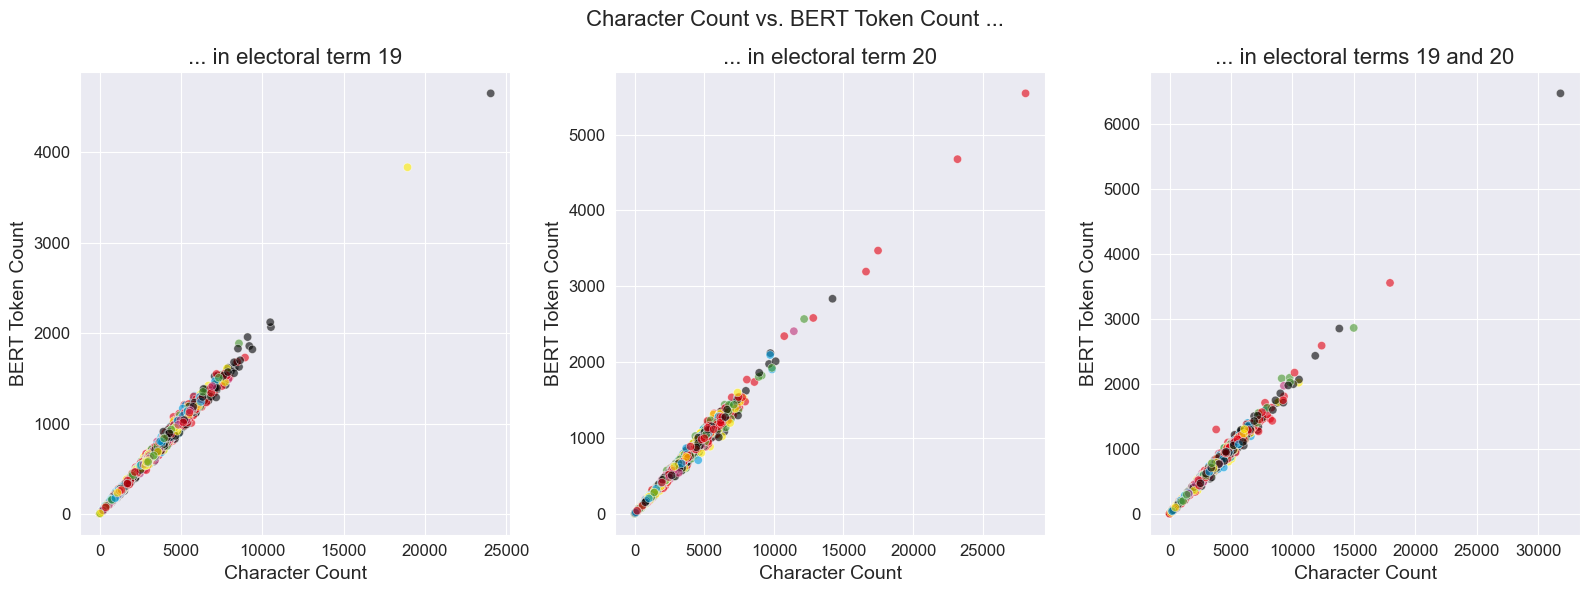

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_21417/3841019278.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data[term], x="faction_abbreviation", y="bert_token_count",
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_21417/3841019278.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data[term], x="faction_abbreviation", y="bert_token_count",
/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_21417/3841019278.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data[term], x

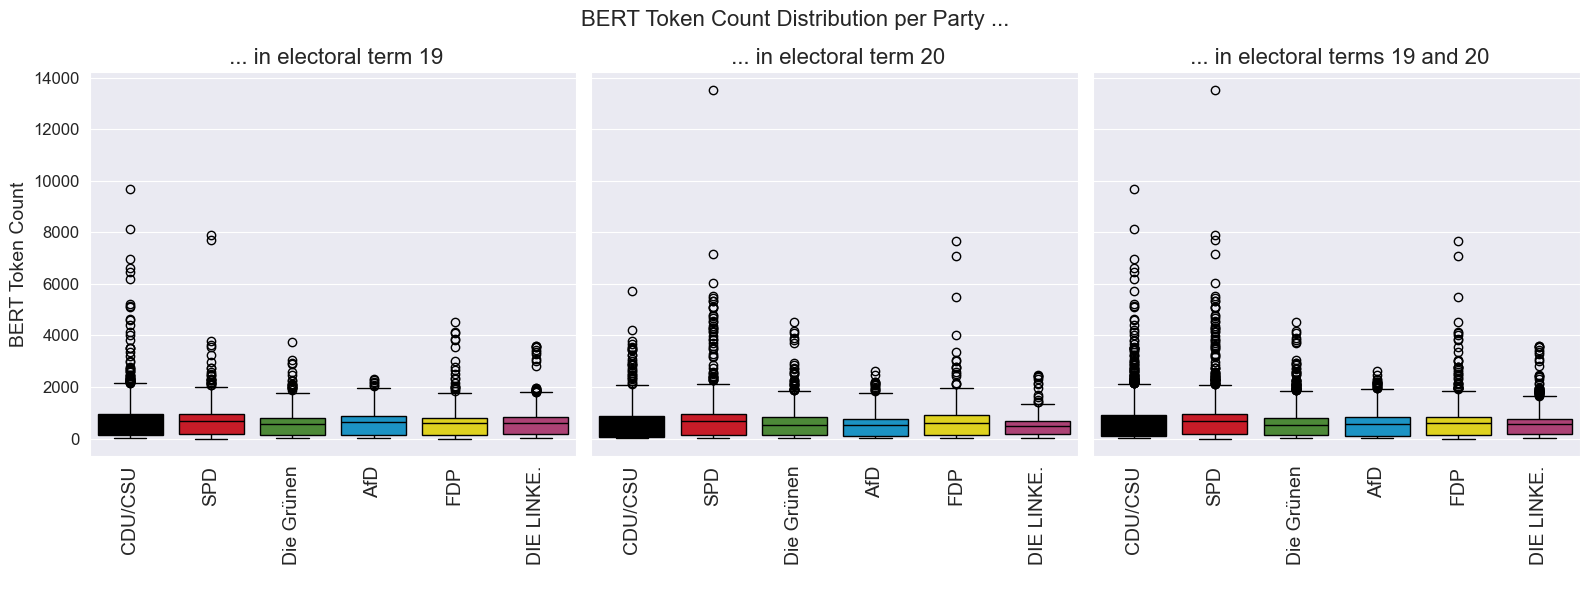

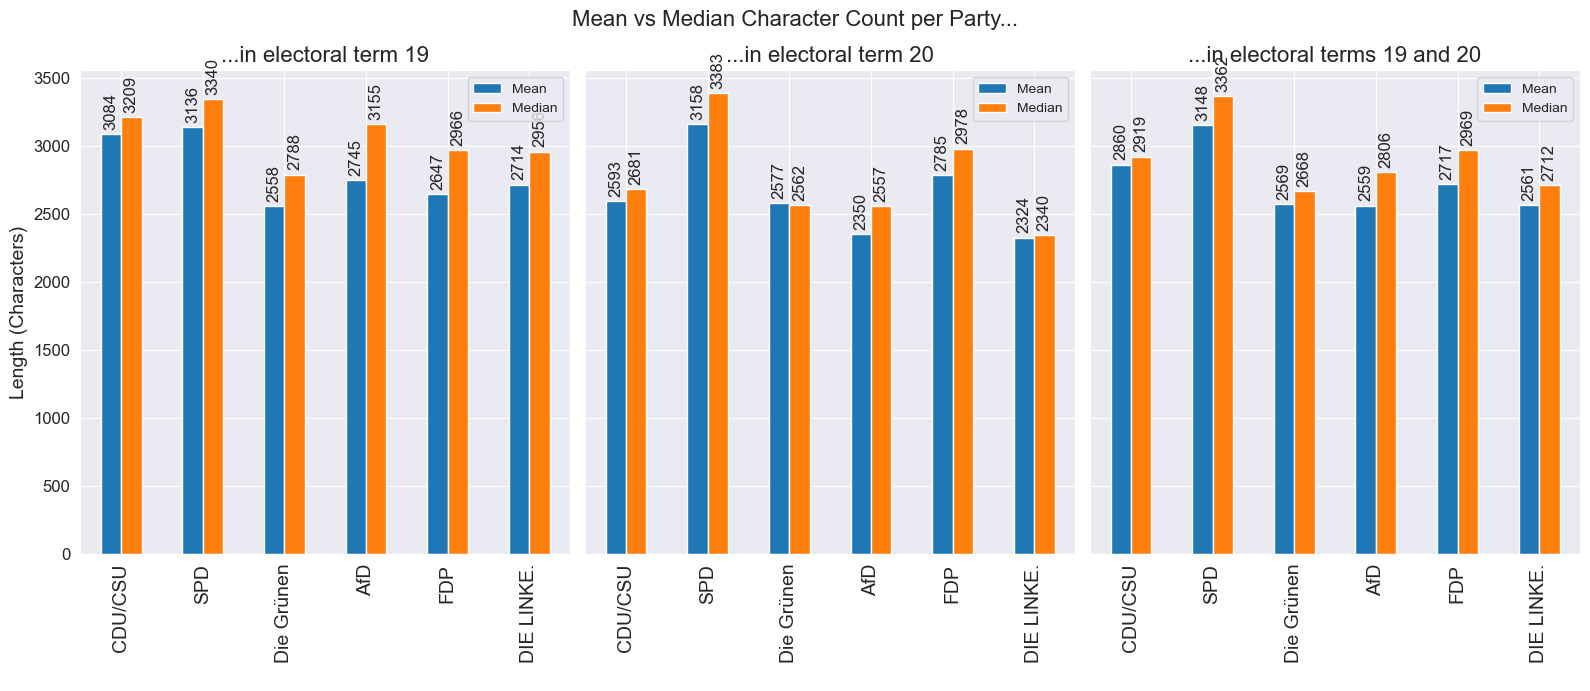


### Correlation between Character and Token Length per Term:

| Term | Pearson Correlation |
|------|----------------------|
| 19 | 0.9973 |
| 20 | 0.9959 |
| 19_20 | 0.9966 |

### Linear Regression – bert_token_count ~ char_count

- Slope (tokens/char):     0.2006
- Intercept:               4.52
- R² (explained variance): 0.9933
- Inverted:                4.99 chars per token (on average)


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


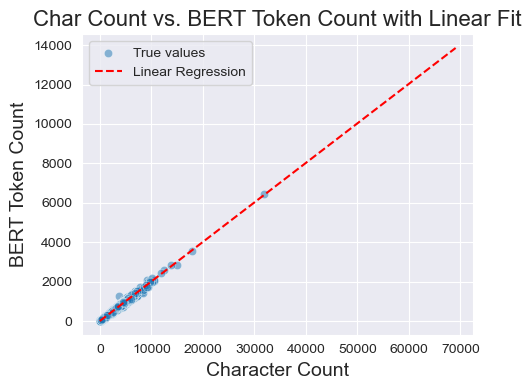


### Average Characters per Token by Party (for the 19th and 20th electoral terms combined):

Party           | Chars per Token | Tokens per Char
---------------------------------------------
AfD             |            4.90 | 0.2043
CDU/CSU         |            5.02 | 0.1991
DIE LINKE.      |            4.89 | 0.2047
Die Grünen      |            4.91 | 0.2035
FDP             |            5.01 | 0.1996
SPD             |            5.01 | 0.1994

### Token/Char Ratio – Statistical Summary:
count    65041.000000
mean         0.210272
std          0.033351
min          0.125000
25%          0.195701
50%          0.204204
75%          0.213970
max          0.600000
Name: token_char_ratio, dtype: float64


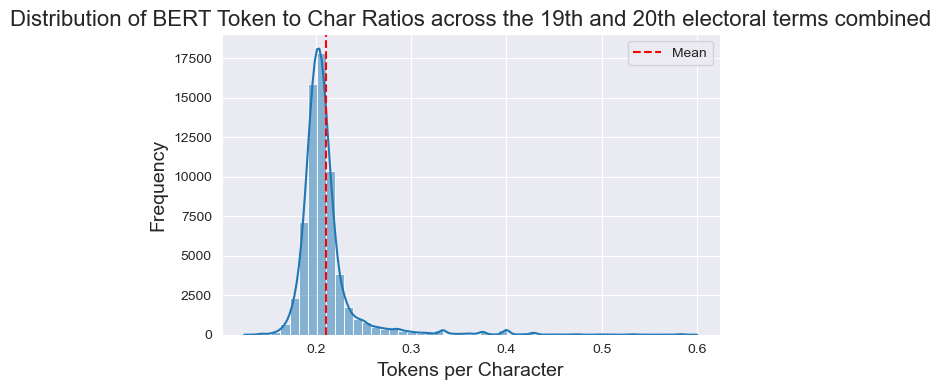


### Markdown Table: Avg. and Median Speech Lengths (Chars & Tokens)

| Term | Party       | Mean Chars | Median Chars | Mean Tokens | Median Tokens |
|------|-------------|------------|---------------|-------------|----------------|
| 19 | CDU/CSU     | 3083.8 | 3209.0 | 615.4 | 638.5 |
| 19 | SPD         | 3136.1 | 3339.5 | 631.8 | 673.0 |
| 19 | Die Grünen  | 2558.5 | 2787.5 | 524.2 | 568.0 |
| 19 | AfD         | 2744.8 | 3155.0 | 563.3 | 644.0 |
| 19 | FDP         | 2646.5 | 2966.0 | 536.3 | 595.0 |
| 19 | DIE LINKE.  | 2713.8 | 2956.5 | 553.9 | 594.5 |
| 20 | CDU/CSU     | 2592.5 | 2681.0 | 525.1 | 540.0 |
| 20 | SPD         | 3158.2 | 3383.0 | 633.5 | 681.0 |
| 20 | Die Grünen  | 2577.0 | 2561.5 | 523.4 | 519.0 |
| 20 | AfD         | 2349.9 | 2557.0 | 482.8 | 523.0 |
| 20 | FDP         | 2785.0 | 2978.0 | 557.4 | 598.0 |
| 20 | DIE LINKE.  | 2323.9 | 2340.0 | 475.1 | 480.5 |
| 19_20 | CDU/CSU     | 2860.5 | 2919.0 | 574.4 | 587.0 |
| 19_20 | SPD         | 3147.8 | 3362.0 | 632.7 

In [2]:
"""
4. Length Distribution  –  Characters and BERT Tokens per Speech:
"""
# Load faction abbreviation map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Custom order and color mapping in Plots
order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
party_colors = {
    "CDU/CSU": "#000000",         # black
    "SPD": "#E3000F",             # red
    "Die Grünen": "#46962B",  # green
    "FDP": "#FFED00",             # yellow
    "AfD": "#009EE0",             # blue
    "DIE LINKE.": "#BE3075",      # magenta
}

# Prepare container and tokenizer
all_data = {}
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

for term in [19, 20]:
    # load speech data
    df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_DIR / f"speech_content_{term}.pkl")
    valid_ids = [0, 3, 4, 5, 7, 15, 25]
    df = df[df["faction_id"].isin(valid_ids)].copy() # Remove speeches by independent members (faction_id == 18) and faction_id==-1
    df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.

    # Apply faction map to get party labels
    df["faction_abbreviation"] = df["faction_id"].map(faction_map)
    # Replace long name with short name for display
    df["faction_abbreviation"] = df["faction_abbreviation"].replace({"Bündnis 90/Die Grünen": "Die Grünen"})

    # Compute character and BERT-token lengths
    tqdm.pandas(desc="Calculating speech lengths")
    df["char_count"] = df["speech_content"].progress_apply(len)
    df["bert_token_count"] = df["speech_content"].progress_apply(lambda x: len(tokenizer.tokenize(x)))

    # combine datasets
    all_data[str(term)] = df.copy()

# Combine 19 + 20 → 19_20 without re-tokenizing
all_data["19_20"] = pd.concat([all_data["19"], all_data["20"]], ignore_index=True)


# Plot 1: Scatterplot – Character Count vs BERT Tokens
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, term in enumerate(["19", "20", "19_20"]):
    df_sample = all_data[term].sample(n=min(2000, len(all_data[term])), random_state=42)
    sns.scatterplot(data=df_sample, x="char_count", y="bert_token_count",
                    hue="faction_abbreviation", palette=party_colors, alpha=0.6, ax=axs[i])
    axs[i].set_title(f"... in electoral {'terms 19 and 20' if term == '19_20' else f'term {term}'}", fontsize=16)
    axs[i].set_xlabel("Character Count", fontsize=14)
    axs[i].set_ylabel("BERT Token Count", fontsize=14)
    axs[i].tick_params(labelsize=12)
    axs[i].legend_.remove()
plt.suptitle("Character Count vs. BERT Token Count ...", fontsize=16)
plt.tight_layout()
plt.show()


# Plot 2: Boxplot – BERT Tokens per Party
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
for i, term in enumerate(["19", "20", "19_20"]):
    sns.boxplot(data=all_data[term], x="faction_abbreviation", y="bert_token_count",
                palette=party_colors, order=order, ax=axs[i])
    axs[i].set_title(f" ... in electoral {'terms 19 and 20' if term == '19_20' else f'term {term}'}", fontsize=16)
    axs[i].set_xlabel(" ")
    axs[i].tick_params(axis='x', rotation=90, labelsize=14)
    axs[i].tick_params(axis='y', labelsize=12)
    if i == 0:
        axs[i].set_ylabel("BERT Token Count", fontsize=14)
plt.suptitle("BERT Token Count Distribution per Party ...", fontsize=16)
plt.tight_layout()
plt.show()


# Plot 3: Barplot - Mean vs Median Char Count per Party
fig, axs = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
char_stats_summary = {}

for i, term in enumerate(["19", "20", "19_20"]):
    df = all_data[term]
    mean_char = df.groupby("faction_abbreviation")["char_count"].mean()
    median_char = df.groupby("faction_abbreviation")["char_count"].median()
    mean_tok = df.groupby("faction_abbreviation")["bert_token_count"].mean()
    median_tok = df.groupby("faction_abbreviation")["bert_token_count"].median()

    char_stats_summary[term] = pd.DataFrame({
        "Mean Chars": mean_char,
        "Median Chars": median_char,
        "Mean Tokens": mean_tok,
        "Median Tokens": median_tok
    }).loc[order]

    stats_df = pd.DataFrame({
        "Mean": mean_char,
        "Median": median_char
    }).loc[order]

    stats_df.plot(kind="bar", ax=axs[i], color=["#1f77b4", "#ff7f0e"])
    axs[i].set_title(f"...in electoral {'terms 19 and 20' if term == '19_20' else f'term {term}'}", fontsize=16)
    axs[i].set_xlabel(" ")
    axs[i].tick_params(axis='x', rotation=90, labelsize=14)
    axs[i].tick_params(axis='y', labelsize=12)
    if i == 0:
        axs[i].set_ylabel("Length (Characters)", fontsize=14)
    for container in axs[i].containers:
        axs[i].bar_label(container, fmt='%.0f', label_type='edge', padding=3, fontsize=12, rotation=90)

plt.suptitle("Mean vs Median Character Count per Party...", fontsize=16)
plt.tight_layout()
plt.show()


# Report: Correlation Coefficients
print("\n### Correlation between Character and Token Length per Term:\n")
print("| Term | Pearson Correlation |")
print("|------|----------------------|")
for term in ["19", "20", "19_20"]:
    df = all_data[term]
    corr = df[["char_count", "bert_token_count"]].corr().iloc[0, 1]
    print(f"| {term} | {corr:.4f} |")


# Evaluation: How many chars per tokens with a regression model?
df = all_data["19_20"]
X = df[["char_count"]]
y = df["bert_token_count"]

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]           # Wie viele Tokens pro Zeichen
intercept = model.intercept_     # Achsenabschnitt
r2 = model.score(X, y)           # Bestimmtheitsmaß R²

print(f"\n### Linear Regression – bert_token_count ~ char_count\n")
print(f"- Slope (tokens/char):     {slope:.4f}")
print(f"- Intercept:               {intercept:.2f}")
print(f"- R² (explained variance): {r2:.4f}")
print(f"- Inverted:                {1/slope:.2f} chars per token (on average)")

# Plot 4: Regression Plot comparing the original data and the model
plt.figure(figsize=(5, 4))
sns.scatterplot(data=df.sample(2000, random_state=42),
                x="char_count", y="bert_token_count",
                alpha=0.5, label="True values")
# Regression-line
x_vals = np.linspace(df["char_count"].min(), df["char_count"].max(), 500)
y_vals = model.predict(x_vals.reshape(-1, 1))
plt.plot(x_vals, y_vals, color="red", linestyle="--", label="Linear Regression")
# Annotations
plt.title("Char Count vs. BERT Token Count with Linear Fit", fontsize=16)
plt.xlabel("Character Count", fontsize=14)
plt.ylabel("BERT Token Count", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot 5: Regression per party: chars per token
print("\n### Average Characters per Token by Party (for the 19th and 20th electoral terms combined):\n")
print(f"{'Party':15} | Chars per Token | Tokens per Char")
print("-" * 45)

for party in sorted(df["faction_abbreviation"].unique()):
    sub = df[df["faction_abbreviation"] == party]
    X_sub = sub[["char_count"]]
    y_sub = sub["bert_token_count"]
    slope = LinearRegression().fit(X_sub, y_sub).coef_[0]
    if slope != 0:
        print(f"{party:15} | {1/slope:15.2f} | {slope:.4f}")
    else:
        print(f"{party:15} | {'∞':>15} | 0.0000")

# plot histogram of token/char-ratio
df["token_char_ratio"] = df["bert_token_count"] / df["char_count"]

print("\n### Token/Char Ratio – Statistical Summary:")
print(df["token_char_ratio"].describe())

plt.figure(figsize=(6, 4))
sns.histplot(df["token_char_ratio"], bins=50, kde=True)
plt.title("Distribution of BERT Token to Char Ratios across the 19th and 20th electoral terms combined", fontsize=16)
plt.xlabel("Tokens per Character", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.axvline(df["token_char_ratio"].mean(), color='red', linestyle='--', label="Mean")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot 5: Markdown Table Output
print("\n### Markdown Table: Avg. and Median Speech Lengths (Chars & Tokens)\n")
print("| Term | Party       | Mean Chars | Median Chars | Mean Tokens | Median Tokens |")
print("|------|-------------|------------|---------------|-------------|----------------|")
for term in ["19", "20", "19_20"]:
    df = char_stats_summary[term]
    for party in df.index:
        row = df.loc[party]
        print(f"| {term} | {party:11} | {row['Mean Chars']:.1f} | {row['Median Chars']:.1f} | {row['Mean Tokens']:.1f} | {row['Median Tokens']:.1f} |")


## **4 Length Distribution – Characters and BERT Tokens per Speech**

Understanding the distribution of speech lengths is critical in order to prepare the data for classification models (especially transformer-based models like BERT, which impose maximum token limits). To this end, we examine both raw character counts and BERT Token counts of the over 60,000 transcribed speeches from the 19th and 20th legislative periods.


---


### **Linear relationship between Character Count and BERT Token Count**

**Correlation Overview**

| Electoral Term     | Pearson Correlation between Character Count and BERT Token Count |
|--------------------|------------------------------------------------------------------|
| 19                 | 0.9982                                                           |
| 20                 | 0.9974                                                           |
| 19 and 20 combined | 0.9978                                                           |

- **Plot 1 – Character Count vs. BERT Token Count:** By describing a strong diagonal band, all scatterplots (electoral terms 19, 20 and combined) reveal a **near-perfect linear relationship** between character and token counts of speeches. Their high **Pearson correlations** further confirm a strong **linear dependence**.
- This linear relation enables robust **estimations of token count** without computationally expensive repeated tokenization:
    - Using a linear regression model that yields a slope of 0.2006, we can work out that **on average 1 token ≈ 5 characters**.
    - The R² value of 0.9933 indicates truly excellent model fit.
    - Plot 4 visualizes the model fit and shows how tightly the predicted values match the true token counts, underscoring the reliability of character-based approximations. This could for example be useful for detecting over-length samples that exceed BERT's 512-token limit.
- **Plot 5 – Token-to-Character Ratio Distribution:** This histogram exhibits a sharp peak around **0.20 BERT Tokens per Char**, with most speeches falling between 0.19 and 0.21. This narrow concentration supports the stability of the linear relationship across the dataset and suggests that token inflation (e.g., due to repetition or formatting artifacts) is uncommon.

**Party-Level Tokenization Characteristics over the 19th and 20th electoral period combined:**

| Party        | Chars per Token | Tokens per Char |
|--------------|-----------------|-----------------|
| `AfD`        | 4.90            | 0.2043          |
| `CDU/CSU`    | 5.02            | 0.1991          |
| `DIE LINKE.` | 4.89            | 0.2047          |
| `Die Grünen` | 4.91            | 0.2035          |
| `FDP`        | 5.01            | 0.1996          |
| `SPD`        | 5.01            | 0.1994          |

The variation of Per-Party Token-to-Char Ratios across parties is minimal and not operationally significant. However, we can still harvest a real-world interpretation: `DIE LINKE.` and `AfD` tend to use slightly more BERT tokens per character, potentially reflecting stylistic or lexical choices (e.g., more compound or foreign words).

**Implications:**

- Character and token counts are interchangeable for length estimation.
- Character-based heuristics can efficiently detect overlength or underlength speeches.
- The observed regularity allows for uniform truncation strategies, with no need for party-specific handling.


---


### **Plot 2: Boxplot – BERT Token Count Distribution per Party**

- Boxplots reveal that across both terms, speeches exhibit a broad distribution in length, ranging from extremely short interjections with less than 20 BERT tokens to lengthy statements exceeding 2,000 BERT tokens, with some outliers reaching up to ~14,000 tokens.
- However, for the bulk of speeches the boxes reveal, a surprisingly even distribution of length across parties at around **200–1,000 BERT tokens**, suggesting a moderately consistent verbosity across contributions.
- This **consistent distribution across parties** reduces the risk of speech length bias during model training, though outlier handling (e.g., truncation) remains necessary.


---


### **Plot 3: Barplot - Mean and Median Speech Length per Party (Char and Token Counts)**

**Electoral Term 19:**

| Party      | Mean Chars | Median Chars | Mean Tokens | Median Tokens |
|:-----------|------------|--------------|-------------|---------------|
| CDU/CSU    | 3083.8     | 3209.0       | 615.4       | 638.5         |
| SPD        | 3136.1     | 3339.5       | 631.8       | 673.0         |
| Die Grünen | 2558.5     | 2787.5       | 524.2       | 568.0         |
| AfD        | 2744.8     | 3155.0       | 563.3       | 644.0         |
| FDP        | 2646.5     | 2966.0       | 536.3       | 595.0         |
| DIE LINKE. | 2713.8     | 2956.5       | 553.9       | 594.5         |

**Electoral Term 20:**

| Party      | Mean Chars | Median Chars | Mean Tokens | Median Tokens |
|:-----------|------------|--------------|-------------|---------------|
| CDU/CSU    | 2592.5     | 2681.0       | 525.1       | 540.0         |
| SPD        | 3158.2     | 3383.0       | 633.5       | 681.0         |
| Die Grünen | 2577.0     | 2561.5       | 523.4       | 519.0         |
| AfD        | 2349.9     | 2557.0       | 482.8       | 523.0         |
| FDP        | 2785.0     | 2978.0       | 557.4       | 598.0         |
| DIE LINKE. | 2323.9     | 2340.0       | 475.1       | 480.5         |


Across both terms, SPD consistently delivers the longest speeches, while DIE LINKE. and AfD tend to speak more concisely. Interestingly, all parties display higher medians than means, indicating that some extremely short speeches pull the mean downward.
Classifier inputs vary in average length depending on party, which could lead to differences in representation quality if no normalization strategy is applied (e.g., cutting too short speeches out).


---


## **Conclusion**

Overall, the speech length characteristics are remarkably uniform across parties and electoral terms. This regularity simplifies downstream modeling, as it reduces the need for party-specific handling. The strong linear correlation between character and token length also enables efficient preprocessing decisions without sacrificing precision.

**Next steps may include:**
- Applying cutoff thresholds
- Investigating how length affects model confidence or class bias
- Testing whether long speeches yield more accurate party predictions due to richer semantic content

**Implications for Model Design**
- Since many speeches exceed 512 tokens—the default input limit for `bert-base`—we observed a non-trivial share of data requiring **truncation** or **segmentation strategies**.
- Conversely, **short speeches (<128 tokens)** are relatively rare but not negligible, raising concerns about **information sparsity** and potential class imbalance.


---


## **After this deepdive we now finally take a look at some example datapoints:**



In [2]:
# Define valid faction IDs
valid_ids = [0, 3, 4, 5, 7, 15, 25]

# Load speech data
speech_19 = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_19)
speech_20 = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_20)
speech_df = pd.concat([speech_19, speech_20], ignore_index=True)

# Load contributions_simplified
contrib_19 = pd.read_pickle(PATHS.FINAL_CONTRIB_SIM_19)
contrib_20 = pd.read_pickle(PATHS.FINAL_CONTRIB_SIM_20)
contrib_df = pd.concat([contrib_19, contrib_20], ignore_index=True)

# Clean data
speech_df = speech_df[speech_df["position_short"] != "Presidium of Parliament"]
speech_df = speech_df[speech_df["faction_id"].isin(valid_ids)]
speech_df["char_len"] = speech_df["speech_content"].str.len()

# Load faction abbreviations
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]
speech_df["faction_abbreviation"] = speech_df["faction_id"].map(faction_map)

# Function to insert contributions into speech
def insert_contributions(text, speech_id, contributions_simplified):
    def handle_match(match):
        try:
            pos = int(match.group().strip("{}()"))
            contrib = contributions_simplified[
                (contributions_simplified["speech_id"].astype(int) == speech_id) &
                (contributions_simplified["text_position"].astype(int) == pos)
            ]
            if not contrib.empty:
                return " ".join(contrib["content"].astype(str))
        except Exception:
            pass
        return ""

    return re.sub(r'\(\{\d+\}\)', handle_match, text)

# Print one example per party with inserted contributions
for faction_id in valid_ids:
    subset = speech_df[speech_df["faction_id"] == faction_id]
    mid_example = subset.iloc[(subset["char_len"] - 2000).abs().argsort()[:1]].iloc[0]

    speech_id = mid_example["id"]
    clean_text = insert_contributions(mid_example["speech_content"], speech_id, contrib_df)

    print(f"\n{'='*100}")
    print(f"Faction: {mid_example['faction_abbreviation']} (faction_id={faction_id})")
    print(f"Speaker: {mid_example['first_name']} {mid_example['last_name']} | Date: {pd.to_datetime(mid_example['date'], unit='s').date()} | Length: {mid_example['char_len']} characters\n")
    print(clean_text)


Faction: AfD (faction_id=0)
Speaker: Stephan Brandner | Date: 2022-09-29 | Length: 2000 characters



Frau Präsidentin! Meine Damen und Herren! Die Deutsche Nachhaltigkeitsstrategie gibt es seit 2017. Die Nationale Nachhaltigkeitsstrategie seit 2002 – erst Schröder, dann Merkel, jetzt Scholz mit seiner hellbraunen Truppe. Und was ist bisher daraus geworden? Nichts!

Ich bin jetzt der 26. Redner in dieser Debatte. 22‑mal haben wir bisher heiße klimaschädliche Altparteienluft gehört. „Warum?“, frage ich mich. Ich sage Ihnen, warum: weil Sie seit 20 Jahren in der Nachhaltigkeit herumstochern, sich im Nachhaltigkeitssumpf herumsuhlen, und es hat zu nichts geführt.

(Dr. Jan-Niclas Gesenhues [BÜNDNIS 90/DIE GRÜNEN]: Besser als im rechten Sumpf!)

Der bisherige Erfolg Ihrer Nachhaltigkeit ist: Sie haben Deutschland nachhaltig geschadet. Sie haben Deutschland nachhaltig ruiniert. Unser Deutschland steht nachhaltig am Abgrund,

(Beifall bei der AfD)

und zwar von diesem Abgrund nicht mehr wei

# **From Data Insights to Model Design – A Guided Path**

Based on our in-depth analyses of the speech dataset — including class distributions, speaker variation, temporal patterns, and length characteristics — we now begin to construct our classification pipelines. Rather than proceeding blindly, we take an **evidence-based approach** to develop a robust strategy for building high-performing models: each modeling decision is grounded in prior empirical observations by investigating how **[class merges](ML-Task-1_BSW_Confusion_Experiment.ipynb), [sequence length](ML-Task-1_Speech-Length-Experiment.ipynb), [vectorization](ML-Task-1_Vectorization-Experiment.ipynb) and [padding](ML-Task-1_Sliding_Window_Experiment.ipynb) strategies, as well as [text preprocessing routines](ML-Task-1_Preprocessing-Experiment.ipynb)** impact classifier performance.

## **complementary treatment strategy:**

**Deep learning** architectures such as BERT and **traditional Machine Learning** approaches like SVMs differ fundamentally in how they process and represent input. As a result, **findings from one class of models cannot be directly transferred to the other**. We therefore adopt a **complementary treatment strategy**, tailoring preprocessing and model design choices specifically to the underlying assumptions and capacities of each modeling paradigm.


## **Summary of Empirical Findings Across Experiments**

Our cumulative experiments yield a consistent picture: **speech length, embedding strategy, and preprocessing must be jointly optimized in alignment with model architecture**. Longer speeches consistently outperform shorter ones due to their richer semantic content and party-specific language patterns. Among BERT configurations, **mean pooling over token embeddings (with truncation at 512 tokens)** remains the most robust and computationally efficient strategy. For classical models like SVMs, **TF-IDF representations on minimally preprocessed full-length speeches** deliver the strongest results. Crucially, our most recent evaluation shows that **aggressive preprocessing harms both model types**, especially BERT, which depends on natural language syntax and punctuation. In contrast, **SVMs benefit from surface structure and lexical variation** if paired with high-dimensional n-gram features. These findings collectively reinforce that **preprocessing is not a neutral step**, but a powerful modeling decision in its own right.


## **Heads-up: We have one heavyweight 🐘 left for you**

In addition to the lean BERT/SVM baselines, we also fine-tune Longformer-GottBERT (over 4000 tokens) to test the upper performance bound on our Bundestag speech corpus.
- Huge context window → can ingest almost every speech end-to-end.
- Requires ≥ 30 GB GPU (A100) or a long CPU run.
- 🐘 lives in [ML_Task_1_Long_Context_Model.ipynb](ML_Task_1_Long_Context_Model.ipynb)